# BEE 4750 Homework 3: Uncertain Sea-Level Rise and Levee Reliability

**Name**: Sinahy 

**ID**: 5139172

> **Due Date**
>
> Friday, 10/06/23, 9:00pm

## Overview

### Instructions

This assignment asks you to conduct a Monte Carlo analysis of levee
reliability in the face of uncertain changes to local sea levels. You
will propagate uncertainty in equilibrium climate sensitivity through
the energy balance model to obtain a distribution of temperatures, which
will then drive a model of sea-level rise. You will finally use this
distribution to assess the probability that a planned levee will achieve
its desired reliability standard.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [1372]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/Downloads/hw03`


In [1373]:
using Random
using Plots
using LaTeXStrings
using Distributions
using CSV
using DataFrames
using Statistics

## Problems (Total: 40 Points)

### Problem 1 (12 points)

Recall from class that the simple energy balance model (EBM) of
planetary energy balance links changes in radiative forcing ($F$) to
global mean temperature ($T$) changes through the discretized equation
$$T_{i+1} = T_{i} + \frac{F_i - \lambda T_i}{cd} \times \Delta t,$$
where $i$ is the current time step, $c = 4.184 \times 10^6$
J/K/m<sup>2</sup> is the heat capacity of water per unit area, $d$ is
the (uncertain) depth of the mixing layer, $\Delta t$ is the annual time
step in seconds and $\lambda = F_{\text{2xCO}_2}/S$ is the climate
feedback parameter in W/m<sup>2</sup>/$^\circ$ C, where $S$ is the
equilibrium climate sensitivity (the uncertain equilibrium temperature
change resulting from a doubling of atmospheric CO<sub>2</sub>).
Finally, while total radiative forcing can be the result of non-aerosol
and aerosol effects, we do not know the relative intensity of aerosol
forcing, so we represent this with an uncertain aerosol scaling factor
$\alpha$.

We can implement this model with the following Julia function. We will
assume an ocean mixing depth $d = 100$ m and an aerosol scaling factor
$\alpha = 1.3$ so we can focus on the uncertainty in $S$.

The last technical concern is that “global mean temperature” does not
make sense in absolute terms as a marker of climate change. Instead, we
typically refer to temperature changes relative to some historical
pre-industrial baseline. In this case, we will use the period from
1880-1900, though this choice can vary.

In [1374]:
# we need to split up the aerosol and non-aerosol forcings when we call the function
function energy_balance_model(S, forcing_aerosol, forcing_non_aerosol)
    d = 100 # ocean mixing depth [m]
    α = 1.3 # aerosol scaling factor
    F2xCO₂ = 4.0 # radiative forcing [W/m²] for a doubling of CO₂
    λ = F2xCO₂/S
    
    c = 4.184e6 # heat capacity/area [J/K/m²]
    C = c*d # heat capacity of mixed layer (per area)

    F = forcing_non_aerosol + α*forcing_aerosol # radiative forcing

    Δt = 31558152.0 # annual timestep [s]
    
    T = zero(F)
    for i in 1:length(F)-1
        T[i+1] = T[i] + (F[i] - λ*T[i])/C * Δt
    end
    # return temperature anomaly relative to 1880-1900 baseline
    return T .- mean(T[1:21]) 
end

energy_balance_model (generic function with 1 method)

Finally, we need to load some radiative forcing data. We will use the
radiative forcing scenario RCP 8.5. We can load this data, which is in a
`.csv` (comma-delimited) file, into a `DataFrame`, which is a tabular
data structure. Rows and columns in a `DataFrame` can be accessed using
their numerical index (like a matrix), but columns also have names; you
can access a particular column in a dataframe `df` by name using
`df.colname` or `df[:, "colname"]`.

Of note: this data set goes from 1750–2500, so you will need to take
care to make sure you are using the right years at each step. For
example, here we will constrain the data to 1880–2100, which is the
period we are interested in.

In [1375]:
# The CSV is read into a DataFrame object, and we specify that it is comma delimited
forcings_all_85 = CSV.read("data/ERF_ssp585_1750-2500.csv", DataFrame, delim=",")

# get the years corresponding to the forcings
t = Int64.(forcings_all_85[!,"year"]) # Ensure that years are interpreted as integers
# find the indices of the years 1880 and 2100
# we can do this with the indexin function
time_bounds = indexin([1880, 2100], t)
years = time_bounds[1]:time_bounds[2] # create range of years

# Separate out the individual components
forcing_co2_85 = forcings_all_85[years,"co2"]
# Get total aerosol and non-aerosol forcings
forcing_aerosol_rad_85 = forcings_all_85[years,"aerosol-radiation_interactions"]
forcing_aerosol_cloud_85 = forcings_all_85[years,"aerosol-cloud_interactions"]
forcing_aerosol_85 = forcing_aerosol_rad_85 + forcing_aerosol_cloud_85 # aerosol forcings
forcing_total_85 = forcings_all_85[years,"total"] 
forcing_non_aerosol_85 = forcing_total_85 - forcing_aerosol_85 # non-aerosol forcings

221-element Vector{Float64}:
  0.42741479112315905
  0.4487940147601447
  0.4900144276528058
 -0.019811270078689047
 -1.480725700367619
 -0.3154905163510021
  0.233186559774844
  0.2923308952663089
  0.45833872365810924
  0.5168189581089915
  ⋮
  9.879065698371564
  9.946850640754889
 10.002169546141578
 10.061009359425011
 10.115684195707905
 10.182946497594184
 10.249699157847772
 10.331407709334023
 10.424544495740134

For this assignment, you can use the `forcing_aerosol_85` and
`forcing_non_aerosol_85` vectors as is to correspond to the relevant
forcings. You will need to use the vector `t` to find the appropriate
years for analysis.

#### Problem 1.1 (3 points)

Assume that $S$ is distributed according to
$\text{LogNormal}(\log(3.2), \log{2}/3)$ (as in class). Draw 10,000
samples from this distribution and make a histogram.

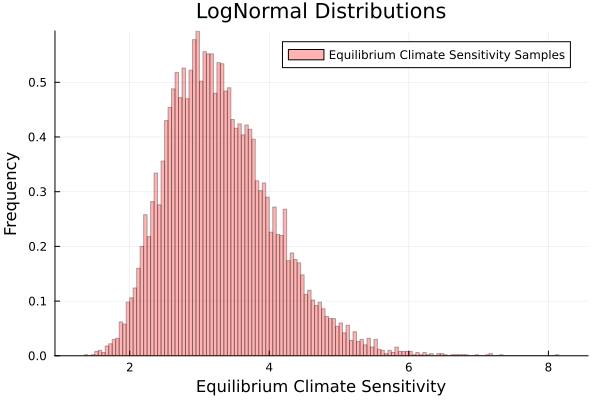

In [1376]:
using Random
using Plots

#parameters for the LogNormal distribution
μ = log(3.2)
σ = log(2) / 3
num_samples = 10000

#generate random samples from the LogNormal distribution
samples = rand(LogNormal(μ, σ), num_samples)

#plot histogram
histogram(samples, bins=150, normalize=true, 
xlabel="Equilibrium Climate Sensitivity", ylabel="Frequency",
label="Equilibrium Climate Sensitivity Samples", alpha=0.3, 
title = "LogNormal Distributions",
color=:red)

#### Problem 1.2 (5 points)

Use the EBM to propagate your samples of $S$ to a distribution of global
mean temperature. Plot the median and 90% predictive distribution
(between the .05 and .95 quantiles) from 1880-2100.

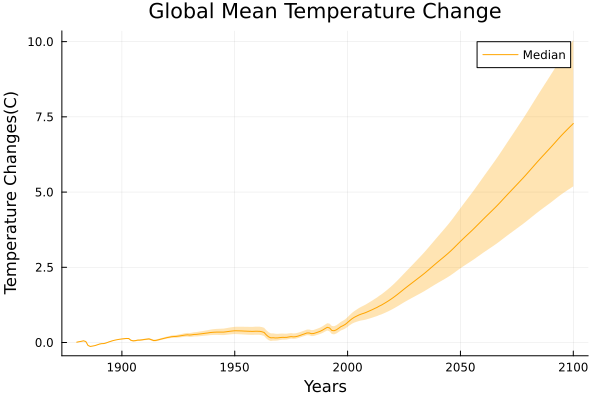

In [1377]:
years = 1880:2100

#ensure lengths are the same so mathemcatical functions can work  
#temperature_simulations = zeros(Float64, length(samples), length(years))
temperature_simulations = zeros(length(samples), length(years))

#generates temperature data from functino above
for i in 1:length(samples)
    temperature_simulations[i, :] = energy_balance_model(samples[i], forcing_aerosol_85, forcing_non_aerosol_85)
end

#calculate medians and distributions 
median_temp = median(temperature_simulations, dims = 1)[:]
lower_quantile = [quantile(temperature_simulations[:, i], 0.05) for i in 1:size(temperature_simulations, 2)]
upper_quantile = [quantile(temperature_simulations[:, i], 0.95) for i in 1:size(temperature_simulations, 2)]

#plot mean temperature by pushing difference of the medians and quantiles
plot(years, median_temp, 
    ribbon = (median_temp .- lower_quantile, upper_quantile .- median_temp),
    fillalpha = 0.3, 
    label = "Median", 
    legend=:topright, 
    xlabel = "Years", 
    ylabel= "Temperature Changes(C)", 
    title = "Global Mean Temperature Change", 
    color=:orange)

#### Problem 1.3 (4 points)

Make a histogram of global mean temperature projections in 2100. If you
compare this distribution to the distribution of $S$ from Problem 1.1,
what do you observe?

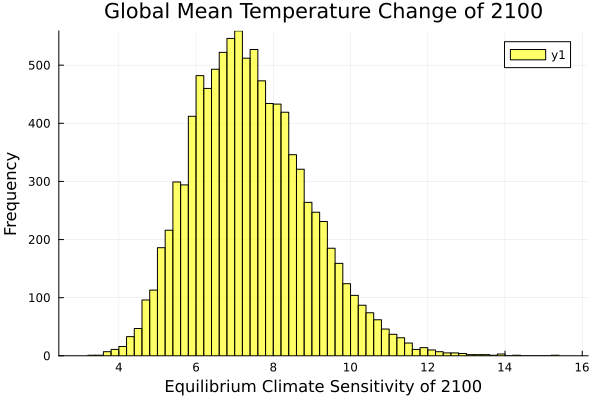

In [1378]:
histogram(temperature_simulations[:, 221], 
fillalpha = 0.6,
xlabel = "Equilibrium Climate Sensitivity of 2100", 
ylabel = "Frequency", 
title = "Global Mean Temperature Change of 2100", 
color=:yellow)

The histogram above has twice the x distrubution compared to the distribution of S. Both distributions are more towards the left. Additionally, I used 10,000 samples to have some variability. 

### Problem 2 (15 points)

Changes to global temperatures cause changes in global sea levels
through several mechanisms, including thermal expansion (the change in
ocean volume due to increased heat content) and melting land-based ice.
One simple way to represent this link is through the following model,
proposed by [Rahmstorf (2007)](https://doi.org/10.1126/science.1135456).

$$\frac{dH}{dt} = a(T-T_0),$$

where $H$ is the global mean sea level in mm, $T$ is global mean
temperature, $T_0$ is an equilibrium temperature (where there is no
change in sea levels), and $a$ is a proportionality constant. This model
can be discretized to give $$H_{i+1} - H_i = a (T_i - T_0).$$

Note that, like with global mean temperature, the notion of “global mean
sea level” does not make sense in absolute terms (were sea levels ever
at “zero”?). Instead, we want to normalize this relative to some
historical baseline. In this case (with a view towards Problem 3), we
will compute our sea levels relative to the 2010 sea level. Note that in
addition to the model parameters, we also need an initial sea-level
parameter $H_0$ which will give us the right anomaly level.

The best estimates for these parameters are:

-   $a = 1.86$;
-   $H_0 = -223$;
-   $T_0 = -0.62$

#### Problem 2.1 (5 points)

Write a function `sea_level_model()` to implement the mathematical
sea-level rise model described above. It should take in needed
parameters and a vector of temperatures and return a vector of sea
levels. To test your function, use the provided temperature series
`historical_temps` (read in below) to compute the global mean sea level
anomaly in 2022 (the last year of the dataset) with the parameter values
above; you should get a value of approximately 40mm.

In [1379]:
historical_temp_data = CSV.read("data/HadCRUT.5.0.1.0.analysis.summary_series.global.annual.csv", DataFrame, delim=",")
# column 2 is the temperature anomaly, column 1 is the year
temp_bds = indexin([1880, 1900], historical_temp_data[!, 1]) # find the index of 2010 for normalization
historical_temp_data[:, 2] .-= mean(historical_temp_data[temp_bds[1]:temp_bds[2], 2])
historical_temps = historical_temp_data[temp_bds[1]:end, 2]

143-element Vector{Float64}:
  0.07297116761904765
  0.15655772761904765
  0.09327316761904769
  0.04232884761904765
 -0.10351681238095234
 -0.08232033238095232
 -0.03210037238095231
 -0.10998251238095236
  0.00942435761904764
  0.13890768761904768
  ⋮
  1.0616748976190478
  1.2139176176190476
  1.3217303776190477
  1.2339774976190476
  1.1514572476190477
  1.2798758476190477
  1.3115970476190477
  1.1506591476190478
  1.1896871476190476

In [1380]:
#using CSV
#a = 1.86
#global mean constants 
#H0 = 223.0
#T0 = -.62 

#retrieve numbers from historical_temps and set to T
#T = historical_temps
#set sea level same vector size as T
#H = zeros(length(T)) 

#define model setting the first parameters for H
#function sea_level_model(T, a, H0, T0)
    #H[1] = H0
    
    #implement sea level equation to run through temp numbers
    #for i in 2:length(T)
     #   H[i] = H[i-1] + a * (T[i] - T0)
    #end

    #H_updated = zeros(length(T))
    #H_updated[1] = H0 - H[end-12]

    #for x in 2:length(T)
     #   H_updated[x] = H_updated[x-1] + a * (T[x] - T0)
    #end
    #return H_updated
#end
#retrieve numbers from historical_temps and set to H 
#H = sea_level_model(T, a, H0, T0)

#set 2022 as end parameter 
#H_2022 = H[end]

#println("Global Sea level anomaly in 2022: $H_2022 mm")


In [1381]:
using CSV

#define model setting the first parameters for H
function sea_level_model(a, H0, T0, historical_temps)
    sea_levls = zeros(length(historical_temps))
    sea_levls[1] = H0 #H=sea levels
    
    #implement sea level equation to run through temp numbers
    for i in 2:length(historical_temps)
        sea_levls[i] = sea_levls[i-1] + a * (historical_temps[i] - T0)
    end

    sea_levls .-= sea_levls[(findfirst(s -> s == 2010, years))]

end

a = 1.86
#global mean constants 
H0 = 223.0
T0 = -.62 

H = sea_level_model(a, H0, T0, historical_temps)
H_2022 = H[end]

println("Global Sea level anomaly in 2022: $H_2022 mm")


Global Sea level anomaly in 2022: 39.54335225065722 mm


#### Problem 2.2 (5 points)

Evaluate `sea_level_model()` using the projected temperature ensemble
from Problem 1. Plot the 90% projection interval of the sea levels.

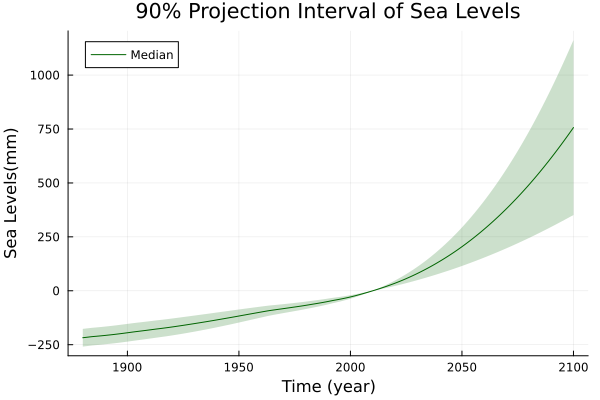

In [1382]:
yrs = 1880:2100
sea_level_proj = zeros(length(samples), length(yrs))
#sea_level_proj = zeros(size(temperature_simulations))

#for i = 1:size(temperature_simulations)[1]
    #sea_level_proj[i, :] .= sea_level_model(a, H0, T0, temperature_simulations[i, :])
#end
#for i = 1:size(temperature_simulations)[1]
    #sea_level_proj[i, :] .= sea_level_model(temperature_simulations[i, :], a, H0, T0)
#end

for i in 1:length(samples)
    sea_level_proj[i, :] = sea_level_model(a, H0, T0, temperature_simulations[i, :])
end

#median_temp2 = median(sea_level_proj, dims=1)[:]'
#lower_quantile2 = [quantile(sea_level_proj[:, i], 0.05) for i in 1:length(yrs)]
#upper_quantile2 = [quantile(sea_level_proj[:, i], 0.95) for i in 1:length(yrs)]

#median_temp2 = median(sea_level_proj, dims=1)[:]
#lower_quantile2 = [quantile(sea_level_proj[:, i], 0.05) for i in 1:size(sea_level_proj, 2)]
#upper_quantile2 = [quantile(sea_level_proj[:, i], 0.95) for i in 1:size(sea_level_proj, 2)]


#median_temp2 = median(sea_level_proj, dims=2)
#lower_quantile2 = quantile(sea_level_proj, dims=2)
#upper_quantile2 = quantile(sea_level_proj, dims=2)

lower_quantile2 = quantile.(eachcol(sea_level_proj), 0.05)
upper_quantile2 = quantile.(eachcol(sea_level_proj), 0.95)
median_temp2 = quantile.(eachcol(sea_level_proj), 0.5)


plot(yrs, median_temp2, 
    ribbon = (upper_quantile2 .- lower_quantile2),
    fillalpha = .2,
    label = "Median", 
    legend = :topleft,
    xlabel = "Time (year)", 
    ylabel = "Sea Levels(mm)", 
    title="90% Projection Interval of Sea Levels",
    color=:darkgreen)

In [1383]:
#yrs = 1880:2100

##
#sea_level_proj = zeros(length(samples), length(yrs))
#sea_level_proj = zeros(size(temperature_simulations))

##
#for i = 1:size(temperature_simulations)[1]
    #sea_level_proj[i, :] .= sea_level_model(a, H0, T0, temperature_simulations[i, :])
#end
#for i = 1:size(temperature_simulations)[1]
 #   sea_level_proj[i, :] .= sea_level_model(temperature_simulations[i, :], a, H0, T0)
#end

##
#for i in 1:length(samples)
    #sea_level_proj[i, :] .= sea_level_model(temperature_simulations[i, :], a, H0, T0)
#end

#median_temp2 = median(sea_level_proj, dims=1)[:]'
#lower_quantile2 = [quantile(sea_level_proj[:, i], 0.05) for i in 1:length(yrs)]
#upper_quantile2 = [quantile(sea_level_proj[:, i], 0.95) for i in 1:length(yrs)]

#median_temp2 = median(sea_level_proj, dims=1)[:]
#lower_quantile2 = [quantile(sea_level_proj[:, i], 0.05) for i in 1:size(sea_level_proj, 2)]
#upper_quantile2 = [quantile(sea_level_proj[:, i], 0.95) for i in 1:size(sea_level_proj, 2)]

#median_temp2 = median(sea_level_proj, dims=2)
#lower_quantile2 = quantile(sea_level_proj, dims=2)
#upper_quantile2 = quantile(sea_level_proj, dims=2)

#median_temp2 = quantile.(eachcol(sea_level_proj, 0.5))
#lower_quantile2 = quantile.(eachcol(sea_level_proj, 0.05))
#upper_quantile2 = quantile.(eachcol(sea_level_proj, 0.95))

#plot(yrs, median_temp2, 
#    ribbon = (median_temp2 .- lower_quantile2, upper_quantile2 .- median_temp2),
 #  label = "Median", 
  #  legend = :topleft,
   # xlabel = "Time (year)", 
    #ylabel = "Mean Temperature Projections(C)", 
   # title="90% Projection Interval of Sea Levels",
    #color=:darkgreen)

#### Problem 2.3 (5 points)

Make a histogram of the sea-level anomaly in 2100. What can you observe
about how the ECS uncertainty has impacted sea-level uncertainty under
this radiative forcing scenario? What might the implications be of only
using the best-estimate ECS value?

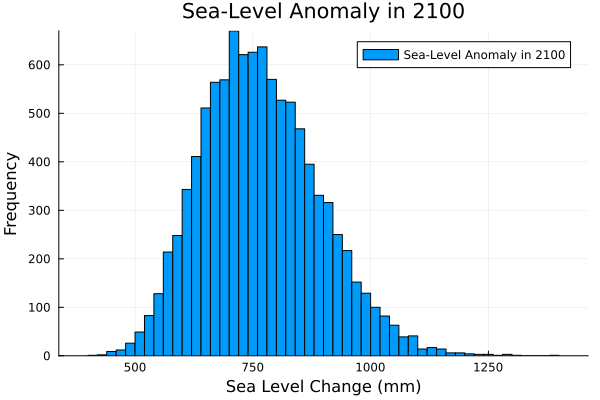

In [1384]:
##sea_levels_2100 = sea_level_proj[:, 221]

years_20 = 1880:2100
sea_levels_3000 = sea_level_proj[:, findfirst(years_20.== 2100)]

histogram(sea_levels_3000, 
    label = "Sea-Level Anomaly in 2100",
    xlabel = "Sea Level Change (mm)", 
    ylabel = "Frequency", 
    title="Sea-Level Anomaly in 2100")

The ECS uncertainity has been impacted by centralizing it around the 700 mm sea level change. The implications are that having the best estimate can give you the most accurate data for the sea level anomaly and its change. 

In [1385]:
#histogram(sea_level_proj[:, 221], 
    #label = "Sea-Level Anomaly in 2100",
    #xlabel = "Time (year)", 
    #ylabel = "Sea-Level Anomaly (mm)", 
    #title="Sea-Level Anomaly in 2100")

### Problem 3 (13 points)

You’ve been asked to consult on a levee reliability analysis. For
context, levees in the United States are supposed to only fail once in
100 years, or, in other words, to have at most a 1% chance of failure in
a given year. We will assume for this problem that the only way in which
a levee fails is by being overtopped (note: this is unrealistic).

We can assess the probability of levee overtopping by comparing its
height to a distribution of extreme sea levels. A common approach is to
look at the distribution of the highest sea level each year. These
extreme sea levels can be obtained by combining the absolute sea level
(we will use our distribution of global sea levels for this), the rate
of subsidence (how much the ground sinks), and the distribution of storm
tides (the highest tide level, which is often the result of storm surges
combining with high tide).

Assume for this problem that:

1.  the annual rate of subsidence $\nu$ is 1.2mm/yr;
2.  the distribution of annual storm tide maxima, above the mean sea
    level, is (and is expected to continue to be) given by a
    $\text{GeneralizedExtremeValue}(900, 25, 0.3)$ distribution, which
    looks like this:

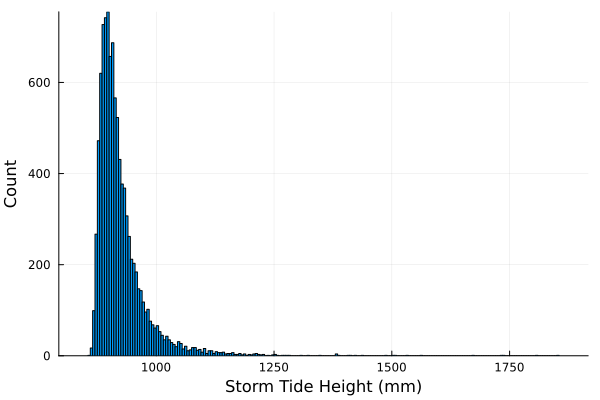

In [1386]:
tide_distribution = GeneralizedExtremeValue(900, 25, 0.3)
    histogram(rand(tide_distribution, 10000), xlabel="Storm Tide Height (mm)", ylabel="Count", legend=:false)

Feel free to just sample from `tide_distribution` in your solution
below.

#### Problem 3.1 (2 points)

How would you use your sea-level simulations and the above information
to compute a distribution of extreme sea levels in 2100 relative to 2010
mean sea level? Write down the approach in clear steps, with equations
as needed.

In order to get the distribution of sea levels, there are 4 pivotal steps:

1) Calculate the total subsidence with the following equation:

$FailureProbability = H - 1.2 * x$

2) Find the max tide using the rand(lognormal) method from problem 1:

$lognormalsamp = rand(LogNormal(log(3.2), log(2)/(3), samples = 10000))$

3) Find sea level max by using graph from problem 2: 

$maxtide = sealevelmodel(tidedistribution[i, :], a, H0, T0)$

4) Incorporate the substidence and the max tide for 3.2 histogram by getting the 
distribution of 2100 sea levels relative to 2010 mean sea level:
    
$tidelevelproj = sealevelmodel(tidedistribution[i, :], a, H0, T0)$


#### Problem 3.2 (3 points)

Follow the steps above and produce a histogram of the extreme sea levels
in 2100 relative to 2010.

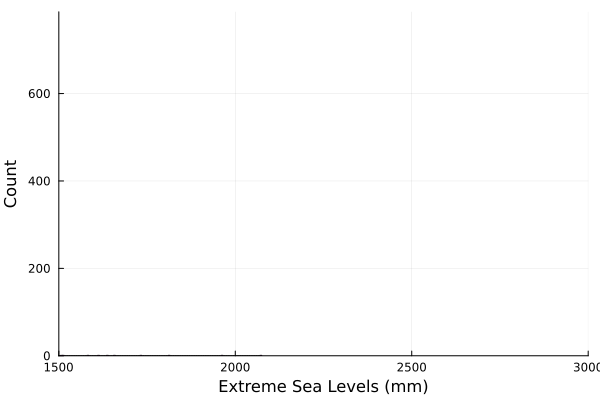

In [1387]:
subs = 1.2

total_subs = subs * (2100 - 2010 + 1)

max_tides = rand(tide_distribution, 10000)

max_sea_levels = sea_levels_2100 .+ max_tides .+ total_subs

histogram(max_sea_levels, 
    xlabel = "Extreme Sea Levels (mm)",
    ylabel = "Count", 
    legend=:false, 
    xlims = (1500, 3000), 
    color=:purple)

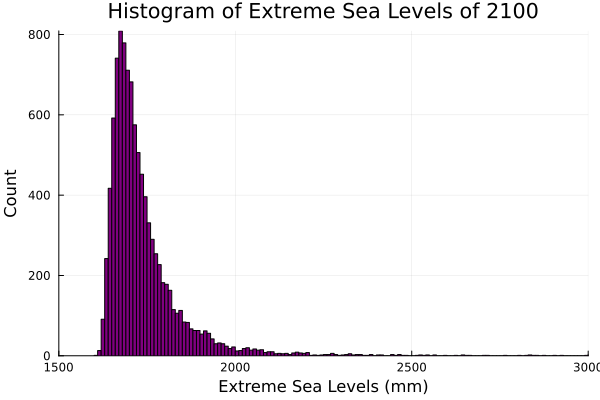

In [1388]:
subs = 1.2

max_tides = rand(tide_distribution, 10000)

total_subs =  max_tides .- subs * (2100 - 2010 + 1)

max_sea_levels = sea_levels_2100 .+ max_tides .+ total_subs

histogram(max_sea_levels, 
    title = "Histogram of Extreme Sea Levels of 2100",
    xlabel = "Extreme Sea Levels (mm)",
    ylabel = "Count", 
    legend=:false, 
    xlims = (1500, 3000), 
    color=:purple)

#### Problem 3.3 (5 points)

The current levee was heightened in 2010 to 2m above the 2010 mean sea
level. Based on your analysis above, what is the probability that the
levee will be overtopped in 2100 (remember that the reliability standard
is 1%)?

In [1389]:
height = 2000 #mm

nums = 0
for i in max_sea_levels
    if i > height
        nums += 1
    end
end

prob = nums / 10000 * 100
println("Probability of levee overtopping in 2100: $prob%")

Probability of levee overtopping in 2100: 3.04%


In [1390]:
height = 2000 #mm

nums = 0
for i in max_sea_levels
    if i > height
        nums += 1
    end
end

prob = nums * 2 / 10000 * 100
println("Probability of levee overtopping in 2100: $prob%")

Probability of levee overtopping in 2100: 6.08%


#### Problem 3.4 (3 points)

Based on your analysis, would you recommend that the levee be heightened
again in the future, and if so, how high? What other information might
you need, if any, to make your recommendation?

## References

List any external references consulted, including classmates.

Worked with Ella Bear and Ruby Pascual. 